### `Step 1: Choose the dataset and convert images into grayscale.`

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose

In [2]:
data_dir = "flowers"

In [3]:
classes = os.listdir(data_dir)
print(classes)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [4]:
X_gray = []
Y_color = []
labels = []

for label, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            img = cv2.imread(img_path)


            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                img = cv2.resize(img, (200, 200))
                
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                X_gray.append(gray)
                Y_color.append(img)
                labels.append(label)

In [5]:
X_gray = np.array(X_gray, dtype=np.float32).reshape(-1, 200, 200, 1) / 255.0
Y_color = np.array(Y_color, dtype=np.float32) / 255.0
labels = np.array(labels)

In [6]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X_gray, Y_color, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [7]:
print(f"#Training set: {len(X_train)}")
print(f"#Validation set: {len(X_val)}")
print(f"#Test set: {len(X_test)}")

#Training set: 3021
#Validation set: 648
#Test set: 648


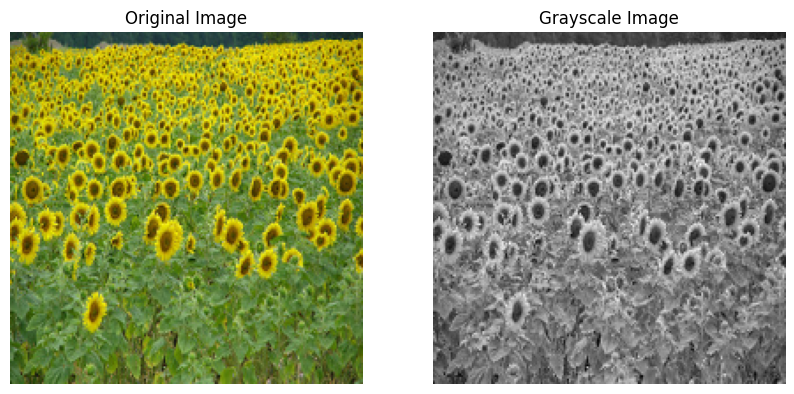

In [8]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(Y_train[0])  
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grayscale Image")
plt.imshow(X_train[0].squeeze(), cmap="gray")  
plt.axis("off")

plt.show()

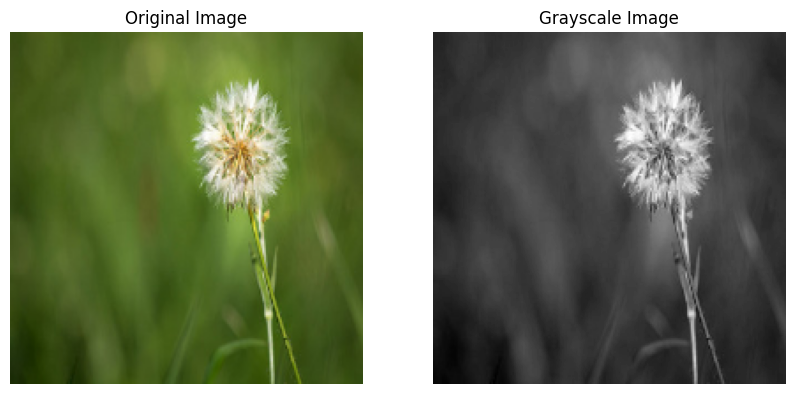

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(Y_train[1])  
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grayscale Image")
plt.imshow(X_train[1].squeeze(), cmap="gray")  
plt.axis("off")

plt.show()

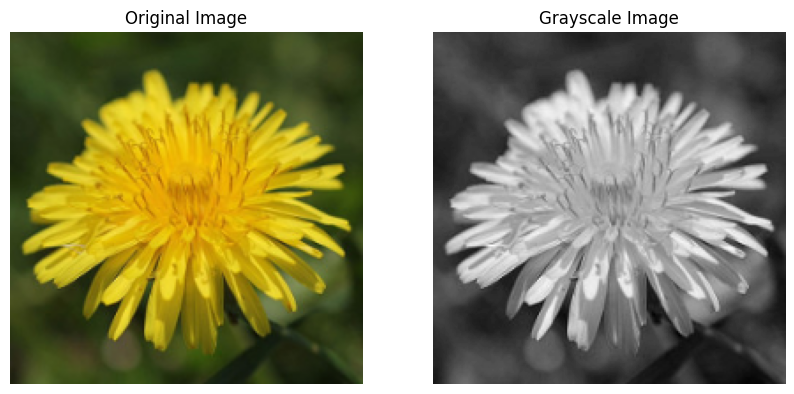

In [10]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(Y_train[10])  
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grayscale Image")
plt.imshow(X_train[10].squeeze(), cmap="gray")  
plt.axis("off")

plt.show()

### `Step 2: Model, ready architecture trained from scratch.`

In [11]:
input_shape = (200, 200, 1)

# ENCODER
def build_encoder(input_layer):
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    return x

# DECODER
def build_decoder(encoded_layer):
    x = Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(encoded_layer)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    return output_layer

In [12]:
input_layer = Input(shape=input_shape)
encoded = build_encoder(input_layer)
decoded = build_decoder(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 200, 200, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 25, 25, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 50, 50, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 50, 50, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 100, 100, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 100, 100, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 200, 200, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 200, 200, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,307 (5.07 MB)

 Trainable params: 1,330,307 (5.07 MB)

 Non-trainable params: 0 (0.00 B)